In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

print(torch.__version__)
print(torchvision.__version__)


2.5.1+cu121
0.20.1+cu121


## 1. Getting a datasets

In [ ]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [ ]:
len(train_data),len(test_data)

(60000, 10000)

In [ ]:
image, labels = train_data[0]
image.shape, labels #(color channel, pixels, pixels)

(torch.Size([1, 28, 28]), 9)

In [ ]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

### 1.1 Visualize

torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

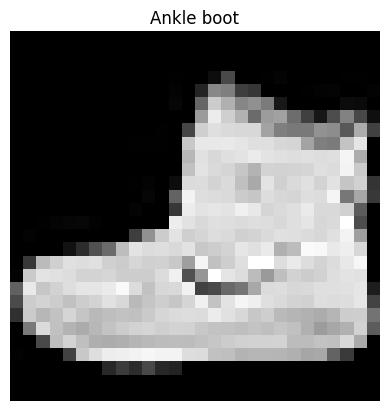

In [ ]:
image, label = train_data[0]
print(image.shape)
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

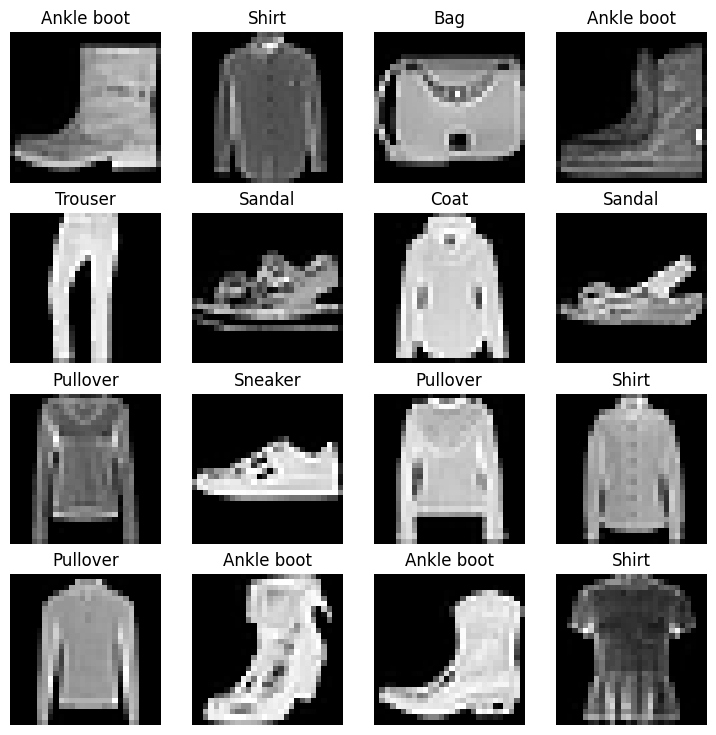

In [ ]:
torch.manual_seed(42)

fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## 2. Prepare dataloader

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=1,
    pin_memory=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=1,
    pin_memory=True
)
train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7b53f80bc0d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b53f80bf100>)

In [ ]:
print(f"Dataloader: {train_dataloader}\nLength: {len(train_dataloader)}\nType: {type(train_dataloader)}")
print(f"Dataloader: {test_dataloader}\nLength: {len(test_dataloader)}\nType: {type(test_dataloader)}")

Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7b53f80bc0d0>
Length: 1875
Type: <class 'torch.utils.data.dataloader.DataLoader'>
Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7b53f80bf100>
Length: 313
Type: <class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
#Check what inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

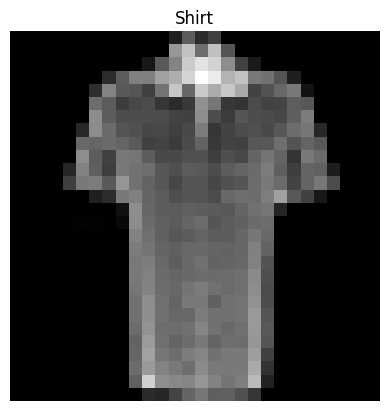

In [ ]:
# Show sample
torch.manual_seed(42)

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
image, label = train_features_batch[random_idx], train_labels_batch[random_idx]
print(image.shape)
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

## 3. Model_0: Build baseline model

In [ ]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)
x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [ ]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_names)
)
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
dummy_x = torch.rand(1,1, 28, 28)
model_0(dummy_x).shape

torch.Size([1, 10])

In [ ]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### Setup loss, optimizer, and metrics

In [ ]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists")
else:
    print("Download helper function")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper_functions.py already exists


In [ ]:
from helper_functions import accuracy_fn, print_train_time

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

### Creating time out experiments

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
start_time = timer()
end_time = timer()
print_train_time(start=start_time, end=end_time, device=None)

Train time on None: 0.000 seconds


3.4268000035808655e-05

## Creating a train and test loop


In [ ]:
from tqdm.auto import tqdm

#Set the seed
torch.manual_seed(42)
#Set timer
start_time = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    #train loss
    train_loss = 0
    #Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer
        optimizer.step()
        train_loss += loss.item()
        if batch % 400 == 0:
            print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples")
    train_loss /= len(train_dataloader)
    #test loss
    test_loss,test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    print(f"Train loss: {train_loss}")
    print(f"Test loss: {test_loss}")
    print(f"Test acc: {test_acc}")
end_time = timer()
total_train_time_model_0 = print_train_time(start=start_time, end=end_time, device=None)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.43026123036146163
Test loss: 0.47663894295692444
Test acc: 83.42651757188499
Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.4302612306316694
Test loss: 0.47663894295692444
Test acc: 83.42651757188499
Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.4302612311522166
Test loss: 0.47663894295692444
Test acc: 83.42651757188499
Train time on None: 42.598 seconds


## Make Predictions and get model 0 results

In [ ]:
torch.manual_seed(42)

def eval_model(model: nn.Module, data_loader: DataLoader, loss_fn: nn.Module, accuracy_fn: nn.Module, device = device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

model_0_results = eval_model(model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device = "cpu")
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## Setup device-agnostic code


In [ ]:
!nvidia-smi

Wed Jan 15 12:43:32 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0              34W /  70W |    165MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 6. Model 1: Building a better model with non-linearity

In [ ]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=input_shape, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=output_shape),
      nn.ReLU(),
      #nn.Linear(in_features=hidden_units, out_features=output_shape)
    )
  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
#Create an instance
torch.manual_seed(42)

model_1 = FashionMNISTModelV1(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)
model_1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [ ]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

### Training and evaluation loop

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """Performs a training with model trying to learn on data_loader."""
  train_loss, train_acc = 0, 0

  # Put model into training mode
  model.train()

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):
    # Put data on target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass (outputs the raw logits from the model)
    y_pred = model(X)

    # 2. Calculate loss and accuracy (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1)) # go from logits -> prediction labels

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (update the model's parameters once *per batch*)
    optimizer.step()

  # Divide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [ ]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Performs a testing loop step on model going over data_loader."""
  test_loss, test_acc = 0, 0

  # Put the model in eval mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Send the data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass (outputs raw logits)
      test_pred = model(X)

      # 2. Calculuate the loss/acc
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1)) # go from logits -> prediction labels

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

In [ ]:
torch.manual_seed(42)

from timeit import default_timer as timer

epochs = 3

start_time = timer()
train_time_start_on_gpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(model = model_1,
          data_loader = train_dataloader,
          loss_fn = loss_fn,
          optimizer = optimizer,
          accuracy_fn=accuracy_fn,
          device = device)
    test_step(model = model_1,
         data_loader = test_dataloader,
         loss_fn = loss_fn,
         accuracy_fn = accuracy_fn,
         device = device)
end_time = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu, end=end_time, device=device)
#

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.09199 | Train acc: 61.34%
Test loss: 0.95636 | Test acc: 65.00%

Epoch: 1
-------
Train loss: 0.78101 | Train acc: 71.93%
Test loss: 0.72227 | Test acc: 73.91%

Epoch: 2
-------
Train loss: 0.67027 | Train acc: 75.94%
Test loss: 0.68500 | Test acc: 75.02%

Train time on cuda: 45.906 seconds


In [ ]:
# Get model_1 results dictionary
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn = accuracy_fn,
                             device = device)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

# Build a CNN

In [ ]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
  """
  Model architecture that replicates the TinyVGG
  model from CNN explainer website.
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        # Create a conv layer - https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1), # values we can set ourselves in our NN's are called hyperparameters
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, # there's a trick to calculating this...
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Output shape of conv_block_2: {x.shape}")
    x = self.classifier(x)
    # print(f"Output shape of classifier: {x.shape}")
    return x

In [ ]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [ ]:
rand_image_tensor = torch.randn(size=(1, 28, 28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [ ]:
# Pass image through model
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

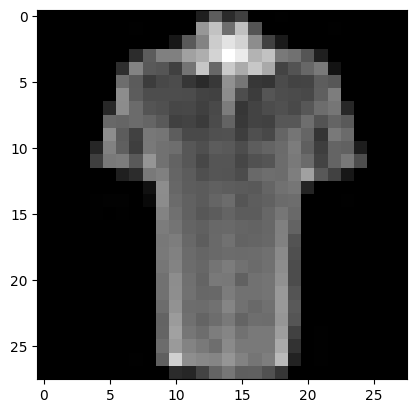

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")

## Stepping through nn.Conv2d

In [ ]:
torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image:\n {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0

In [ ]:
model_2.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
      

In [ ]:
torch.manual_seed(42)
# Create a sinlge conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=(3, 3),
                       stride=1,
                       padding=0)

# Pass the data through the convolutional layer
conv_output = conv_layer(test_image.unsqueeze(0))
conv_output.shape

torch.Size([1, 10, 62, 62])

### Stepping through nn.MaxPool2d()

In [ ]:
print(f"Test image before max pooling: \n{test_image.shape}")
print(f"Test image with unsqeezed dimension : \n{test_image.unsqueeze(0).shape}")

#Create a sample nn.Maxpool2d
maxpool_layer = nn.MaxPool2d(kernel_size=2)
#Pass through conv_layer
conv_output = conv_layer(test_image.unsqueeze(0))
print(f"Test image after conv layer: \n{conv_output.shape}")

#Pass data through the max pool layer
maxpool_output = maxpool_layer(conv_output)
print(f"Test image after max pooling: \n{maxpool_output.shape}")

Test image before max pooling: 
torch.Size([3, 64, 64])
Test image with unsqeezed dimension : 
torch.Size([1, 3, 64, 64])
Test image after conv layer: 
torch.Size([1, 10, 62, 62])
Test image after max pooling: 
torch.Size([1, 10, 31, 31])


In [ ]:
torch.manual_seed(42)
#Create a random tensor
random_tensor = torch.rand(size=(1, 1, 2,2))
print(f"Random tensor: \n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")
#Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

#Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"Random tensor after max pooling: \n{max_pool_tensor}")
print(f"Random tensor after max pooling shape: {max_pool_tensor.shape}")
random_tensor

Random tensor: 
tensor([[[[0.8823, 0.9150],
          [0.3829, 0.9593]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])
Random tensor after max pooling: 
tensor([[[[0.9593]]]])
Random tensor after max pooling shape: torch.Size([1, 1, 1, 1])


tensor([[[[0.8823, 0.9150],
          [0.3829, 0.9593]]]])

### Setup loss and optimizer

In [ ]:
# Setup loss function/eval metrics/optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

### Training and testing

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_2,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.59300 | Train acc: 78.46%
Test loss: 0.40416 | Test acc: 85.48%

Epoch: 1
-------
Train loss: 0.36120 | Train acc: 87.11%
Test loss: 0.34619 | Test acc: 87.42%

Epoch: 2
-------
Train loss: 0.32434 | Train acc: 88.28%
Test loss: 0.32307 | Test acc: 88.14%

Train time on cuda: 50.041 seconds


In [ ]:
# Get model_2 results
model_2_results = eval_model(
     model=model_2,
     data_loader=test_dataloader,
     loss_fn=loss_fn,
     accuracy_fn=accuracy_fn,
     device=device
)

model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3230680823326111,
 'model_acc': 88.13897763578275}

# 8. Compare model results and training time

In [ ]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                                model_1_results,
                                model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.323068,88.138978


In [ ]:
# Add training time to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,42.598116
1,FashionMNISTModelV1,0.685001,75.019968,45.905816
2,FashionMNISTModelV2,0.323068,88.138978,50.041287


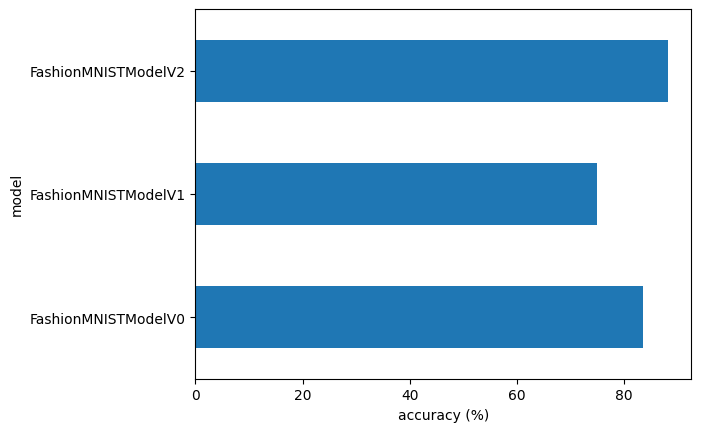

In [ ]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

# 9. Make and evaluate random predictions with best model

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model outputs raw logits)
      pred_logit = model(sample)

      # Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [ ]:
import random
# random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Bag')

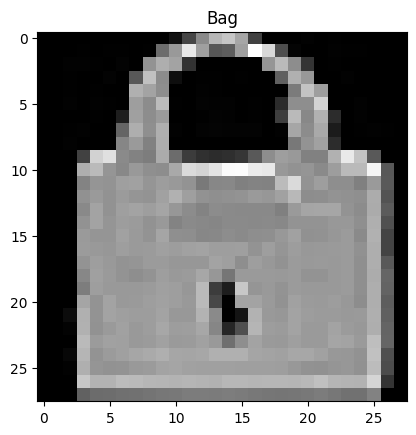

In [ ]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [ ]:
# Make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

# View first two prediction probabilities
pred_probs[:2]

tensor([[1.3431e-02, 8.2001e-04, 3.8074e-03, 1.5691e-03, 1.0374e-03, 2.3096e-05,
         3.6782e-02, 2.2678e-03, 9.4025e-01, 8.9027e-06],
        [2.2202e-01, 3.5388e-02, 9.4617e-02, 1.3510e-01, 1.3934e-02, 9.5723e-04,
         4.9013e-01, 1.1077e-03, 6.2393e-03, 5.0446e-04]])

In [ ]:
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([8, 6, 8, 4, 8, 4, 9, 0, 8])

In [ ]:
test_labels

[8, 6, 8, 4, 8, 4, 9, 0, 8]

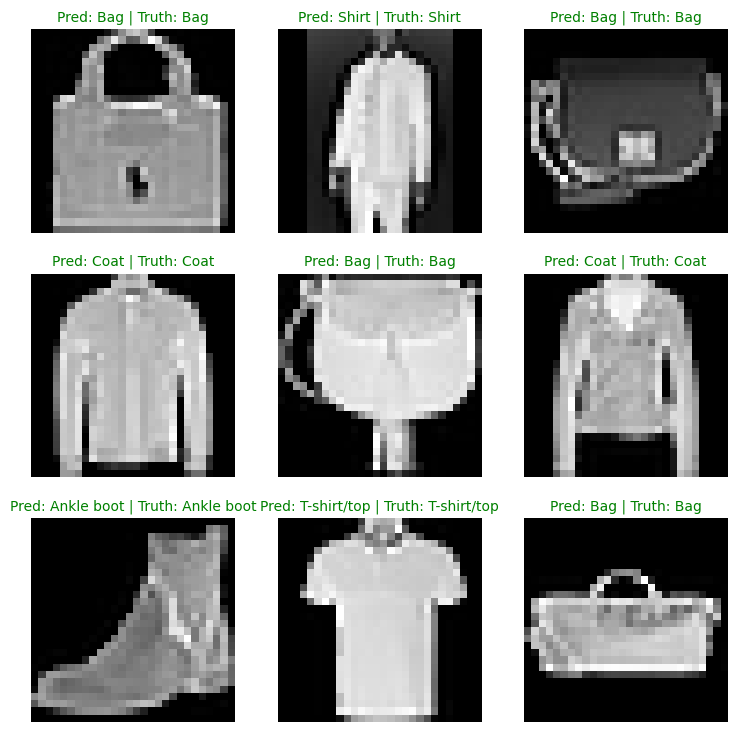

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction (in text form, e.g "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form)
  truth_label = class_names[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False);

# 10. Making a confusion matrix for further prediction evaluation

In [ ]:
# Import tqdm.auto
from tqdm.auto import tqdm


# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # Put prediction on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 2])

In [ ]:
# See if required packages are installed and if not, install them...
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend version should be 0.19.0 or higher")
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 12.7 MB/s eta 0:00:00
mlxtend version: 0.23.3


In [ ]:
import mlxtend
print(mlxtend.__version__)

0.23.3


In [ ]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

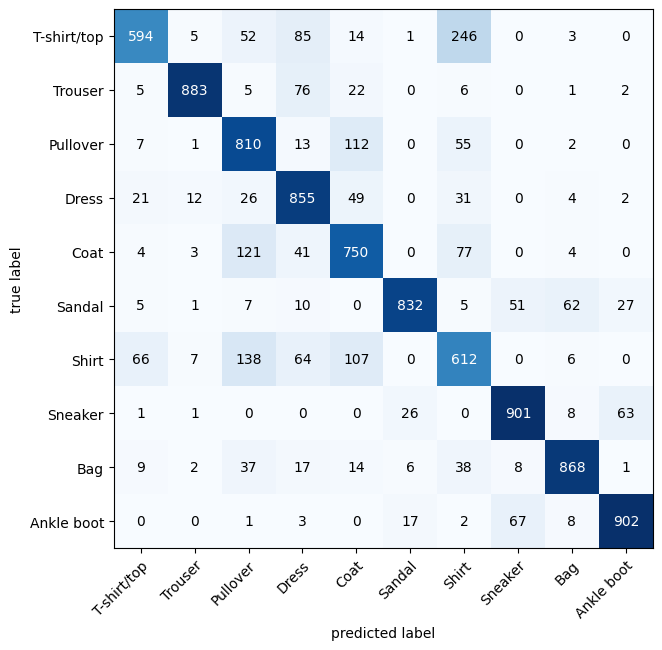

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task = "multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy
    class_names=class_names,
    figsize=(10, 7)
)

# 11. Save and load best performing model

In [ ]:
from pathlib import Path

# Create model dictory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [ ]:
image_shape = [1, 28, 28]

In [ ]:
# Create a new instance
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=len(class_names))

# Load in the save state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send the model to the target device
loaded_model_2.to(device)

<ipython-input-182-d3aa727c7c4d>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3230680823326111,
 'model_acc': 88.13897763578275}

In [ ]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3230680823326111,
 'model_acc': 88.13897763578275}

In [ ]:
# Check if model results are close to each other
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-02)

tensor(True)